In [1]:
!pip uninstall fitz -y
!pip uninstall PyMuPDF -y
!pip install PyMuPDF

In [1]:
import torch
import os
from pathlib import Path
import warnings
from tqdm import tqdm

from razdel import sentenize
import fitz
import re

import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
class PDFDataset(torch.utils.data.Dataset):
    
    def check_pdfs(self):
        self.pdfs = []

        assert Path(f"{self.data_dir}/spbu/pdf").is_dir() == True

        for path in os.listdir(f"{self.data_dir}/spbu/pdf"):
            if os.path.isfile(os.path.join(f"{self.data_dir}/spbu/pdf", path)):
                self.pdfs.append(path)
    
    def __init__(self, data_dir='data'):
        self.data_dir = data_dir
        self.check_pdfs()
    
    def __getitem__(self, idx):
        return {'name': self.pdfs[idx], "path": f"{self.data_dir}/spbu/pdf/{self.pdfs[idx]}"} 
    
    def __len__(self):
        return len(self.pdfs)
    
    def read_pdf(self, idx):
        return open(os.path.join(f"{self.data_dir}/spbu/pdf", self.pdfs[idx]), 'rb')
    

# defects

- специальные символы( <>=+*●}{/∈≤≥Σ тп) resolved
- повторяющиеся пробелы склеить resolved
- процентное содержание буков dont need
- пустые строки убрать resolved
- удалять предложения если в них есть слова введения, оглавление todo
- delete if https: in text resolved
- re.sub("S- ", "") resolved
- replace unix chars todo
- counter по символам, посмотреть всякое говно

In [3]:
dataset = PDFDataset("data")


In [4]:
class PDFParser:
    
    SPECIAL_CHARS = "#^&*+_=<✓α𝑎>/\≡≡Σ∑∈●}{≤≥�åðÿæπ"
    NUMBERS = ("1","2", "3","4" ,"5" ,"6" ,"7" ,"8" ,"9")
    
    def __init__(self):
        return
    
    @staticmethod
    def convert_case(match_obj):
        if match_obj.group(1) is not None:
            return match_obj.group(1)
    
    @staticmethod
    def delete_repeating_whitespaces(sent):
        return re.sub(' +', ' ', sent)
    
    @staticmethod
    def delete_unicode(sent):
        sent = re.sub('\xad', ' ', sent)
        return sent.encode("utf-8", "ignore").decode()

    @staticmethod
    def replace_hyphenation(sent):
        return re.sub("(\S)- ", convert_case, sent)
    
    
    def mark_blocks(self):
        for block in self.blocks:
            if 84 < block['bbox'][0] < 86:
                block['type'] = "text"
            if block['lines'][0]['spans'][0]['font'] == 'CMUSerif-Bold':
                block['type'] = 'title'
            
    def blocks_to_text(self):
        textlines = [] 
        for block in self.blocks:
            block_textlines = []
            for line in block['lines']:
                for span in line['spans']:
                    block_textlines.append(span['text'])
            if not block_textlines[0].startswith("["):
                textlines += block_textlines
        return " ".join(textlines)
    
    def text_to_sents(self, text):
        
        sents = [sent.text for sent in list(sentenize(text))]
        
        
        sents = list(filter(lambda x: not any(c in self.SPECIAL_CHARS for c in x), sents))
        sents = list(filter(lambda x: not x.startswith(self.NUMBERS), sents))
        sents = list(filter(lambda x: not "https:" in x, sents))
        sents = list(filter(lambda x: not re.search(r"[1-9]\.", x), sents))
        
        sents = [self.delete_repeating_whitespaces(sent) for sent in sents]
        sents = [self.replace_hyphenation(sent) for sent in sents]
        sents = [self.delete_unicode(sent) for sent in sents]
        
        sents = list(filter(lambda x: len(x) > 10, sents))
        sents = list(filter(lambda x: len(x) < 512, sents))
        
        return sents 
    
    def get_sentences(self, doc_path):
        try:
            doc = fitz.open(doc_path)
        except:
            return []
        
        self.blocks = []
        
        for page in doc:
            self.blocks += page.get_text("dict", flags=16)['blocks']

        self.mark_blocks()
        self.blocks = list(filter(lambda x: x['type'] == 'text', self.blocks))
        
        return self.text_to_sents(self.blocks_to_text())

In [5]:
parser = PDFParser()

In [116]:
sents = []
for pdf in tqdm(dataset):
    sents += parser.get_sentences(pdf['path'])

100%|██████████████████████████████████████████████████████████████████████████████| 1093/1093 [02:07<00:00,  8.59it/s]


In [117]:
len(sents)

89645

In [101]:
test = 'По дан- ным liveinternet на 2008 год, рунет насчитывает 4392 сайта СМИ, а число блогов значительно больше — по данным Яндекс за 2009 год в русскоязычной блогосфере насчитывается порядка 840000 активных блогов, на которых ежедневно публикуется порядка 300000 постов.'

In [131]:
for sent in sents[:1000]:
    print(sent)

Заключение Список литературы 35 Введение Языки программирования – область, которая активно развивается на протяжении всей истории развития IT, начиная с 50 х годов прошлого века.
Наряду с ультрасовременными языками, основанными на последних разработках, такими как Swift или Kotlin, продолжается и развитие традиционных языков, существующих с 80 х годов прошлого века.
Это в полной мере относится к языку C, простота и эффективность которого сделала его «фактическим стандартом» для программирования встроенных систем и систем реального времени.
На кафедре системного программирования профессором А.Н.Тереховым в течение последних лет разрабатывается язык РуСи [7] [8], который является развитием стандартного языка C в сторону повышения надежности и безопасности программирования.
Перспективным направлением является использование РуСи в проектах, связанных с разработкой встроенного ПО реального времени для различных специальных применений.
По сравнению со стандартным C, РуСи обладает рядом преим

В результате получается вероятностная карта (Рисунок 8) такого же размера как изображение G, которая соответствует вероятности нахождения фрагмента F в каждой точке изображения G. адаптирован к задаче поиска изображений по запросу-образцу.
Мера подобия по значению дескрипторов считается по следующей формуле, взятой из работы [19]: где S D – константная матрица ковариаций (диагональная, квадратная RxR , где R – это размерность вектора дескриптора), которая определяет допустимое отклонение значений дескрипторов.
Если обозначить диагональные элементы a 1 ,..,a R , то чем ближе диагональный элемент a i к нулю, тем важнее, чтобы i -ые элементы дескрипторов совпадали. формируем k похожих групп-кандидатов, содержащих на данном шаге по одному дескриптору.
То есть ищем похожие на d p дескрипторы только среди тех, которые располагаются внутри области радиуса locationDeviation пикселей, центр которой соответствует ожидаемому центру d p значению дескриптор и пересчитываем центр группы-кандидата (с

In [145]:
df = pd.DataFrame({"text": sents})
df.to_csv("spbu_sents_temp.csv", encoding='utf-8')

# find anomalies

In [2]:
import pandas as pd
import seaborn as sns


In [3]:
df = pd.read_csv("spbu_sents_temp.csv")

In [4]:
df['sent_len'] = df.text.apply(len)

In [5]:
df['text_lower'] = df.text.apply(lambda x: x.lower())

In [6]:
df.describe()

,Unnamed: 0,sent_len
count,89645.000000,89645.000000
mean,44822.000000,138.847911
std,25878.426778,72.279883
min,0.000000,11.000000
25%,22411.000000,88.000000
50%,44822.000000,125.000000
75%,67233.000000,174.000000
max,89644.000000,511.000000


<AxesSubplot:xlabel='sent_len', ylabel='Count'>

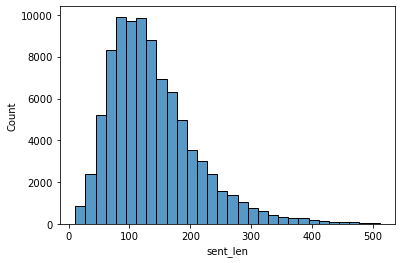

In [7]:
sns.histplot(data=df, x='sent_len', bins=30)

In [8]:
df

,Unnamed: 0,text,sent_len,text_lower
0,0,Заключение Список литературы 35 Введение Языки...,178,заключение список литературы 35 введение языки...
1,1,"Наряду с ультрасовременными языками, основанны...",189,"наряду с ультрасовременными языками, основанны..."
2,2,"Это в полной мере относится к языку C, простот...",176,"это в полной мере относится к языку c, простот..."
3,3,На кафедре системного программирования професс...,235,на кафедре системного программирования професс...
4,4,Перспективным направлением является использова...,161,перспективным направлением является использова...
...,...,...,...,...
89640,89640,В данный момент ведутся работы по ее улучшению...,121,в данный момент ведутся работы по ее улучшению...
89641,89641,"Кроме того, ведется работа по добавлению новых...",73,"кроме того, ведется работа по добавлению новых..."
89642,89642,В соответствие с принципами ОСРВ Embox все час...,212,в соответствие с принципами осрв embox все час...
89643,89643,Файловая система ОСРВ Embox нашла свое примене...,184,файловая система осрв embox нашла свое примене...


In [9]:
full_text = " ".join(list(df.text_lower))

In [10]:
from collections import Counter

In [21]:
i = 0
for sent in df.text_lower:
    if "о" in sent:
        #print(sent)
        i+=1
print(i)

86619


In [12]:
"

Counter(full_text).most_common(1000)

[(' ', 1624829),
 ('о', 1060122),
 ('е', 832318),
 ('и', 779340),
 ('а', 767402),
 ('т', 667002),
 ('н', 653306),
 ('р', 531851),
 ('с', 515464),
 ('в', 408357),
 ('л', 386032),
 ('м', 335071),
 ('к', 311468),
 ('п', 296856),
 ('д', 291838),
 ('я', 232754),
 ('ы', 212098),
 ('у', 201645),
 ('з', 191206),
 ('б', 160790),
 ('ь', 146387),
 (',', 125434),
 ('ч', 123090),
 ('г', 121102),
 ('.', 118896),
 ('й', 116563),
 ('х', 107370),
 ('ж', 77115),
 ('ю', 67277),
 ('ц', 65612),
 ('e', 61989),
 ('a', 47333),
 ('ф', 46768),
 ('t', 46580),
 ('щ', 43563),
 ('i', 43358),
 ('r', 41309),
 ('o', 41204),
 ('s', 38988),
 ('ш', 38461),
 ('n', 37492),
 ('э', 30913),
 ('l', 29342),
 ('c', 27323),
 ('p', 23141),
 ('d', 21474),
 ('m', 21129),
 ('-', 16813),
 ('u', 16412),
 ('g', 14137),
 (')', 14129),
 ('(', 14076),
 ('h', 13967),
 ('f', 12593),
 ('1', 12433),
 ('b', 11370),
 ('[', 10445),
 (']', 10424),
 ('�', 10005),
 (':', 9532),
 ('v', 9377),
 ('î', 8492),
 ('2', 8242),
 ('0', 7949),
 ('y', 7475),
 (

In [ ]:
�åðÿæπ

In [ ]:
replace("»", r'"')
replace("«", r'"')
replace("”", r'"')
replace("“", r'"')



In [ ]:
df.head()

In [ ]:
df[df['sent_len'] < 10]

In [41]:
for sent in list(df[df['sent_len'] < 20].text):
    print(sent)

In [70]:
data = data.replace('\xad', '')
data = data.replace('\u00ad', '')
data = data.replace('\N{SOFT HYPHEN}', '')
data = data.replace('\u200b', '')
data = data.replace('\uf113', '')
data = data.replace('\uf0d8', '')

NameError: name 'data' is not defined